## 模型评估与参数调优实战
### 基于流水线的工作流

In [1]:
%matplotlib inline

import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y) 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [2]:
# 使用pipeline,将多个任务串联起来
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler()), 
                    ('pca', PCA(n_components=2)), 
                    ('clf', LogisticRegression(random_state=1))
                   ])
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


### 使用K折交叉验证评估模型性能
holdout and k-fold cross validation to assess model performance  
Holdout: Train set, Validation set (for tuning and evaluation), Test set (final performance estimate)  

k-Fold: Randomly split the training set in k folds "without replacement". k-1 for training, other one for test.  
Normally used for tuning. After that, use all the (training) samples to get accuracy against the Test set  

In Stratified k-fold cross-validation the class proportions are preserved in each fold to ensure that each fold  
is representative of the class proportions in the training set.  

In [3]:
# 使用sklearn的K折交叉验证
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, random_state=1)
scores = []
for k, (train, test) in enumerate(kfold.split(X_train, y_train)):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s,  Class dist.: %s,  Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

Fold: 1,  Class dist.: [256 153],  Acc: 0.891
Fold: 2,  Class dist.: [256 153],  Acc: 0.978
Fold: 3,  Class dist.: [256 153],  Acc: 0.978
Fold: 4,  Class dist.: [256 153],  Acc: 0.913
Fold: 5,  Class dist.: [256 153],  Acc: 0.935
Fold: 6,  Class dist.: [257 153],  Acc: 0.978
Fold: 7,  Class dist.: [257 153],  Acc: 0.933
Fold: 8,  Class dist.: [257 153],  Acc: 0.956
Fold: 9,  Class dist.: [257 153],  Acc: 0.978
Fold: 10,  Class dist.: [257 153],  Acc: 0.956


In [4]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


In [5]:
# Using scikit-learn builtin functions...
from sklearn.model_selection import cross_val_score
# cross_val_score可以讲不同分块的评估分布到多个CPU上进行处理。
scores = cross_val_score(estimator=pipe_lr,  X=X_train,  y=y_train,  cv=10,  n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
CV accuracy: 0.950 +/- 0.029


### 通过学习及验证曲线来调试算法

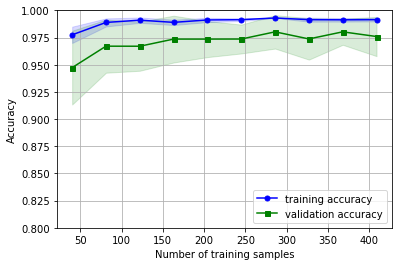

In [6]:
# Learning curves
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = Pipeline([
        ('scl', StandardScaler()), 
        ('clf', LogisticRegression(penalty='l2', random_state=0))
    ])
train_sizes,  train_scores,  test_scores =\
    learning_curve(estimator=pipe_lr,  X=X_train,  y=y_train,  train_sizes=np.linspace(0.1, 1.0, 10), cv = 10, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.ylim([0.8,  1.0])
plt.legend(loc='lower right')
plt.show()

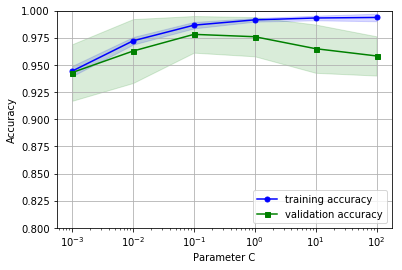

In [7]:
# Validation curves
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
# 使用不同的正则化参数C来绘制曲线。
train_scores, test_scores = validation_curve(
    estimator = pipe_lr,
    X = X_train,
    y = y_train,
    param_name = 'clf__C',
    param_range = param_range,
    cv = 10)

train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.plot(param_range,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(param_range,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')
plt.plot(param_range,test_mean,color='green',marker='s',markersize=5,label='validation accuracy')
plt.fill_between(param_range,test_mean+test_std,test_mean-test_std,alpha=0.15,color='green')
plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.legend(loc='lower right')
plt.show()

### 使用网格搜索调优机器学习模型

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([
        ('scl', StandardScaler()), 
        ('clf', SVC(random_state=1))
    ])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C':param_range,  'clf__kernel':['linear']}, 
              {'clf__C':param_range, 'clf__gamma':param_range, 'clf__kernel':['rbf']}]
gs = GridSearchCV(estimator = pipe_svc, 
                  param_grid = param_grid, 
                  scoring = 'accuracy', 
                  cv = 10, 
                  n_jobs = -1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)

0.978021978022


In [9]:
print(gs.best_params_)

{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [10]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


In [11]:
# 嵌套交叉验证选择算法
# 外部使用K折验证算法，内部使用网格搜索调参
gs = GridSearchCV(estimator = pipe_svc, 
                  param_grid = param_grid, 
                  scoring = 'accuracy', 
                  cv = 2, 
                  n_jobs = -1)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.965 +/- 0.025


In [12]:
from sklearn.tree import DecisionTreeClassifier
# 和上面SVM分类器进行比较，这里使用的简单决策树，只调优了树的深度参数。
gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state=0), 
                  param_grid = [{'max_depth':[1, 2, 3, 4, 5, 6, 7, None]}], 
                  scoring = 'accuracy', 
                  cv = 2, 
                  n_jobs = -1)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
# 由此可见SVM的评分远高于决策树，SVM是用于对此数据集未知数据进行分类的一个好选择。

CV accuracy: 0.921 +/- 0.029


### 了解不同的性能评价指标
Different performance evaluation metrics: Accuracy, Precision, Recall, F1-score

In [13]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
# 混淆矩阵，分别为真正，假负，假正，真负。
print(confmat)

[[71  1]
 [ 2 40]]


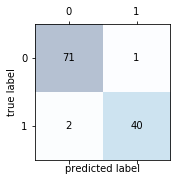

In [14]:
fig,  ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [15]:
# 分别计算精准率，召回率和F1分数
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [16]:
from sklearn.metrics import make_scorer, f1_score
# 构建自己的评分规则，将0作为正类类标，并使用F1分数
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = scorer,
                  cv = 10,
                  n_jobs = -1)

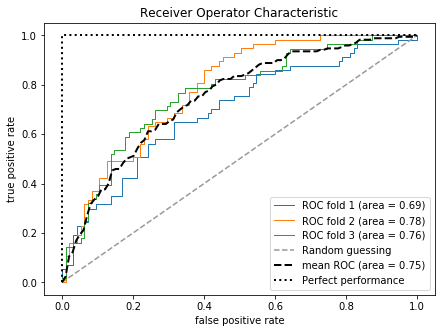

In [17]:
# 绘制ROC AUC曲线
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('clf', LogisticRegression(penalty='l2', random_state=0, C=100.0))
])
X_train2 = X_train[:, [4, 14]]
cv = StratifiedKFold(n_splits=3, random_state=1)
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv.split(X_train2, y_train)):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i + 1, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing')
mean_tpr /= cv.n_splits
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='Perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.show()
# 

In [18]:
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4, 14]])

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
# 计算分类器在单独测试集上的ROC AUC得分
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

ROC AUC: 0.662
Accuracy: 0.711


In [19]:
# 自己定义评分标准，用于多类别分类问题。
pre_scorer = make_scorer(score_func=precision_score, pos_label=1, greater_is_better=True, average='micro')